# YAASS Dataset

### The dataset below includes demographic information and multiple clinical measures taken in 4 populations: healthy controls, those at clinical high risk for psychosis, those at familial high risk, and those diagnosed with schizophrenia.

In [218]:
# Get the username and use that to set-up paths to data and figures
uname  = !whoami
uname = uname[0]
path2code = '/Users/' + uname + '/Work/Expts/Code/'
path2data = '/Users/' + uname + '/Work/Expts/YAASS/Data/'
path2analysis = '/Users/' + uname + '/Work/Expts/YAASS/Analysis/'
path2figs = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/Figures/'

In [219]:
%cd {path2code}

import csv, misc, os, random, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats
from scipy.stats import zscore
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

%R suppressMessages(library('lmerTest'))
%R suppressMessages(library('lsmeans'))
%R lsm.options(disable.pbkrtest=TRUE)
%R suppressMessages(library('effsize')) # Can use this to estimate Cohen's d
%R suppressMessages(library('afex'))
%R suppressMessages(library('QuantPsyc')) #helpful for extracting betas from hierarchical regresssions
%R suppressMessages(library('vcd')) # useful for getting effect sizes from chi-square tests
%R suppressMessages(library('scales'))

/Users/ebarrick/Work/Expts/Code
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['scales', 'vcd', 'grid', 'QuantPsyc', 'MASS', 'boot', 'afex',
       'reshape2', 'effsize', 'lsmeans', 'estimability', 'lmerTest',
       'lme4', 'Matrix', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], 
      dtype='|S12')

### Building the dataframe

In [220]:
#Function to assign names to disorders in FAME dataset
# def dx_name(data):
#     d = {0:'None', 1:'MDD', 2:'Anxiety', 3:'Sub_abuse', 4:'ADHD', 
#          5:'Eating', 6:'Schizotypal', 7:'2_co', 8: '3_co', 9:'4_co','999':'na'}
#     dx = d[data]
#     return dx 

# raw_sh = pd.read_excel(path2data + 'Bx_Paper_YAASS_Feb2017_edit.xlsx')
# raw_sh['Gender'].replace(2, 'female', inplace=True)
# raw_sh['Gender'].replace(1,'male', inplace=True)

# raw_sz = pd.read_excel(path2data + 'SCORE Data_Bx_IRI_SocialFx.xlsx')
# raw_sz['Group'].replace(2, 'SZ', inplace=True)
# raw_sz['Group'].replace(1,'HC',inplace=True)
# raw_sz['Gender'].replace(1,'male',inplace=True)
# raw_sz['Gender'].replace(2,'female',inplace=True)

# raw_fhr = pd.read_excel(path2data + 'FAME_Neuropsych_NEW_edit.xlsx')
# raw_fhr['Group'].replace(1, 'FHR', inplace=True)
# raw_fhr['Gender'].replace(2, 'female', inplace=True)
# raw_fhr['Gender'].replace(1,'male', inplace=True)

# g = raw_fhr.append(raw_sz)

# raw = g.append(raw_sh)
# pd.set_option('display.max_columns', 500)

In [221]:
# raw.to_csv('raw2.csv')

In [222]:
raw = pd.read_excel(path2data + 'raw.xlsx')

In [223]:
raw.head()

,Group,ID,Gender,Age,Education,IQ,IRI_EC,IRI_FS,IRI_PD,IRI_PT,...,SIPS_General,SIPS_Negative,SIPS_Positive,SocAdjScale_SocialLeisure,SocAdjScale_Work,GFS_Role,GFS_Social,DSMDisorder,DSMDisorderType,DSMcomorbidities
0,FHR,2501,female,25,14,99,NaN,NaN,NaN,NaN,...,0.75,0.500000,1.4,NaN,NaN,NaN,NaN,1,7,2
1,FHR,2504,female,29,16,118,21,6,6,23,...,0.50,0.333333,1.0,1.2,1.5,NaN,NaN,1,7,2
2,FHR,2505,male,33,14,95,21,19,5,24,...,0.00,0.000000,0.4,1.9,1.5,NaN,NaN,0,0,0
3,FHR,2506,male,33,13,109,14,15,9,23,...,0.75,1.166667,1.2,1.8,1.4,NaN,NaN,1,4,1
4,FHR,2508,male,28,16,118,18,16,16,23,...,1.00,0.500000,1.4,1.3,1.7,NaN,NaN,0,NaN,0


In [224]:
raw.Group.unique()

array([u'FHR', u'SZ', u'HC', u'CHR'], dtype=object)

### rescaling the IRI for SCORE and YAASS datasets

In [225]:
raw_iri_S = pd.read_excel(path2data + 'IRI_DAS_CERQ_SCORE.xlsx', sheetname='IRI_EB')

In [226]:
raw_iri_Y = pd.read_excel(path2data + 'YAASS_IRI.xlsx', sheetname='IRI_EB')

In [227]:
df = pd.concat([raw_iri_S, raw_iri_Y])

In [228]:
#rescale IRI for HC, CHR, SZ
%R rescale(c(1.0 , 2.0, 3.0, 4.0, 5.0, 6.0), to = c(1.0, 5.0))

array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ])

In [229]:
new = {1: 1, 2: 1.8, 3: 2.6, 4: 3.4, 5: 4.2, 6: 5} 

df1 = df.applymap(lambda d: new.get(d) if d in new else d)

In [230]:
fs = ['1_FS', '5_FS', '7_FS_R', '12_FS_R', '16_FS', '23_FS', '26_FS']
ec = ['2_EC', '4_EC_R', '9_EC', '14_EC_R', '18_EC_R', '20_EC', '22_EC']
pt = ['3_PT_R', '8_PT', '11_PT', '15_PT_R', '21_PT', '25_PT', '28_PT']
pd = ['6_PD', '10_PD', '13_PD_R', '17_PD', '19_PD_R', '24_PD', '27_PD']

df1['FS_total'] = df1[fs].sum(axis=1)
df1['EC_total'] = df1[ec].sum(axis=1)
df1['PT_total'] = df1[pt].sum(axis=1)
df1['PD_total'] = df1[pd].sum(axis=1)

In [249]:
df1 = df1.rename(columns={"Subject": "ID"})
df1.head()

,ID,1_FS,2_EC,3_PT,3_PT_R,4_EC,4_EC_R,5_FS,6_PD,7_FS,...,23_FS,24_PD,25_PT,26_FS,27_PD,28_PT,FS_total,EC_total,PT_total,PD_total
0,27100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,27101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,27102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,27103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,27104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


In [253]:
g = df1[['ID','FS_total', 'EC_total', 'PT_total','PD_total']].copy()

### Demographics

In [233]:
print ('Total Group Count')
raw.groupby('Group')['ID'].nunique()

Total Group Count


Group
CHR    27
FHR    19
HC     38
SZ     26
Name: ID, dtype: int64

In [12]:
#Even split in HC group, more males in HR and SZ group - unsurprising...
#however mostly female in GHR group
print ('Gender by Group')
raw.groupby('Group')['Gender'].value_counts()

Gender by Group


Group        
CHR    male      18
       female     9
FHR    female    14
       male       5
HC     male      22
       female    16
SZ     male      16
       female    10
dtype: int64

Age by Group
Group       
CHR    count    27.000000
       mean     21.629630
       std       4.404090
       min      15.000000
       25%      18.000000
       50%      22.000000
       75%      23.500000
       max      34.000000
FHR    count    19.000000
       mean     27.421053
       std       3.920258
       min      20.000000
       25%      24.500000
       50%      27.000000
       75%      31.000000
       max      33.000000
HC     count    38.000000
       mean     29.763158
       std      11.769025
       min      18.000000
       25%      21.000000
       50%      24.000000
       75%      41.500000
       max      55.000000
SZ     count    26.000000
       mean     38.692308
       std      10.279180
       min      21.000000
       25%      31.250000
       50%      38.500000
       75%      44.750000
       max      58.000000
dtype: float64


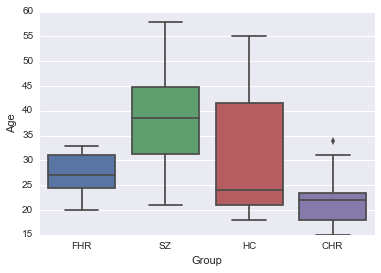

In [13]:
print ('Age by Group')
g=raw.groupby('Group')
print (g.Age.describe())

sns.boxplot(x='Group',y='Age',data=raw)

In [14]:
"""Dataframe dropping participants without an IQ value"""
raw_IQ = raw[np.isfinite(raw['IQ'])]

Group
CHR    106.791667
FHR    117.000000
HC     112.105263
SZ     108.076923
Name: IQ, dtype: float64
Group
CHR    17.688068
FHR     9.779931
HC     11.668367
SZ     13.323432
Name: IQ, dtype: float64


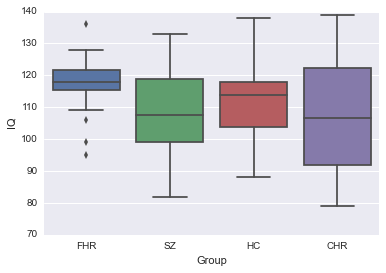

In [15]:
i = raw_IQ.groupby('Group')

print (i.IQ.mean())
print (i.IQ.std())

sns.boxplot(x='Group',y='IQ',data=raw_IQ)

### Looking at Measures

IRI_EC Mean
Group
CHR   -0.111424
FHR   -1.286310
HC     0.605839
SZ     0.184935
Name: IRI_EC_z, dtype: float64
IRI_FS Mean
Group
CHR    0.461403
FHR   -1.232093
HC     0.066177
SZ     0.351513
Name: IRI_FS_z, dtype: float64
IRI_PD Mean
Group
CHR    0.693958
FHR   -1.168771
HC    -0.053762
SZ     0.250582
Name: IRI_PD_z, dtype: float64
IRI_PT Mean
Group
CHR   -0.184382
FHR   -1.220071
HC     0.621240
SZ     0.185722
Name: IRI_PT_z, dtype: float64


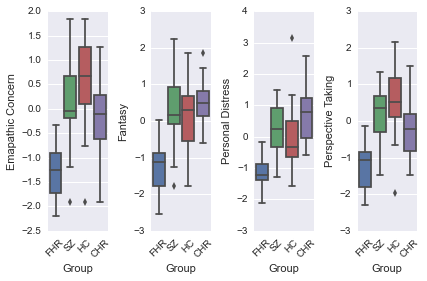

In [16]:
#SCORE and YAASS scored on 5-pt scale, FAME on 6-pt scale. Transformed to z scores.
#FHR scores seem much lower than the other groups...

print('IRI_EC Mean')
print(g.IRI_EC_z.mean())
print('IRI_FS Mean')
print(g.IRI_FS_z.mean())
print('IRI_PD Mean')
print(g.IRI_PD_z.mean())
print('IRI_PT Mean')
print(g.IRI_PT_z.mean())

fig = plt.figure()
iri = fig.add_subplot(141)
sns.boxplot(y='IRI_EC_z', x='Group', data = raw)
plt.ylabel('Emapathic Concern')
plt.xticks(rotation=45)
iri = fig.add_subplot(142)
sns.boxplot(y='IRI_FS_z', x='Group', data = raw)
plt.ylabel('Fantasy')
plt.xticks(rotation=45)
iri = fig.add_subplot(143)
sns.boxplot(y='IRI_PD_z', x='Group', data = raw)
plt.ylabel('Personal Distress')
plt.xticks(rotation=45)
iri = fig.add_subplot(144)
sns.boxplot(y='IRI_PT_z', x='Group', data = raw)
plt.ylabel('Perspective Taking')
plt.xticks(rotation=45)
fig.tight_layout()

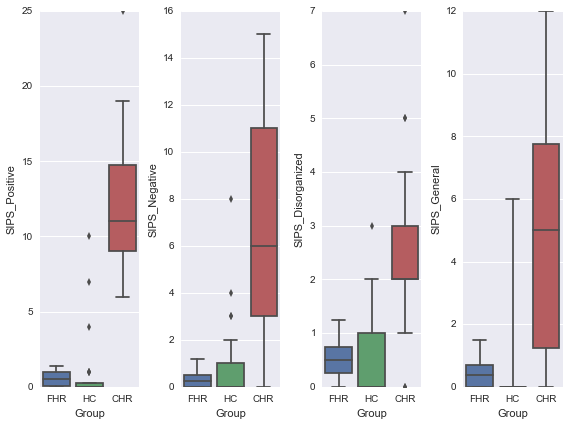

In [17]:
sips = raw[~(raw.Group == 'SZ')]

fig = plt.figure(figsize=(8, 6))
si = fig.add_subplot(141)
sns.boxplot(y='SIPS_Positive', x='Group', data = sips)
si = fig.add_subplot(142)
sns.boxplot(y='SIPS_Negative', x='Group', data = sips)
si = fig.add_subplot(143)
sns.boxplot(y='SIPS_Disorganized', x='Group', data = sips)
si = fig.add_subplot(144)
sns.boxplot(y='SIPS_General', x='Group', data = sips)
fig.tight_layout()

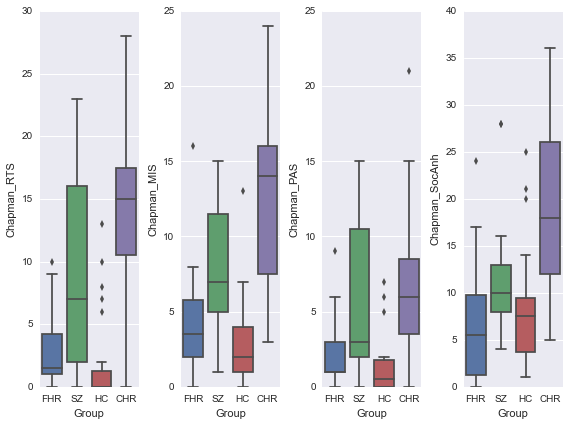

In [18]:
#Waiting on Chapman measures for YAASS

fig = plt.figure(figsize=(8, 6))
chap = fig.add_subplot(141)
sns.boxplot(y='Chapman_RTS', x='Group', data = raw)
chap = fig.add_subplot(142)
sns.boxplot(y='Chapman_MIS', x='Group', data = raw)
chap = fig.add_subplot(143)
sns.boxplot(y='Chapman_PAS', x='Group', data = raw)
chap = fig.add_subplot(144)
sns.boxplot(y='Chapman_SocAnh', x='Group', data = raw)
fig.tight_layout()

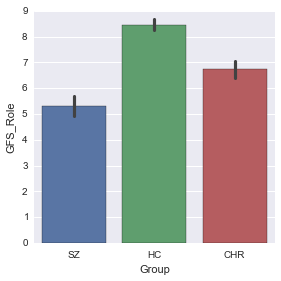

In [19]:
# no measures from FAME
gfs = raw[~(raw.Group == 'FHR')]

sns.factorplot(y='GFS_Role',x='Group',units='ID',ci=68,kind='bar',data=gfs)

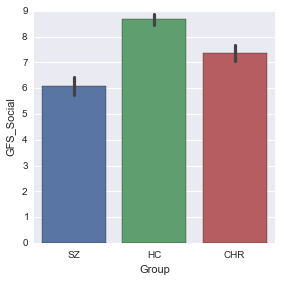

In [20]:
#No measures from FAME
sns.factorplot(y='GFS_Social',x='Group',units='ID',ci=68,kind='bar',data=gfs)

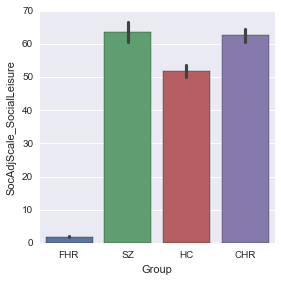

In [21]:
sns.factorplot(y='SocAdjScale_SocialLeisure',x='Group',units='ID',ci=68,kind='bar',data=raw)

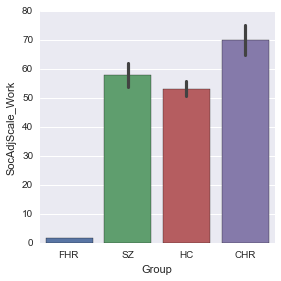

In [22]:
sns.factorplot(y='SocAdjScale_Work',x='Group',units='ID',ci=68,kind='bar',data=raw)

### IRI and SAS

                                     Df Sum Sq Mean Sq F value   Pr(>F)    
as.factor(IRI_EC_z)                  28  36393    1300  20.514 1.82e-15 ***
as.factor(Group)                      3  17648    5883  92.846  < 2e-16 ***
as.factor(IRI_EC_z):as.factor(Group) 27   4694     174   2.744  0.00215 ** 
Residuals                            38   2408      63                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


/Users/ebarrick/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


(30, 100)

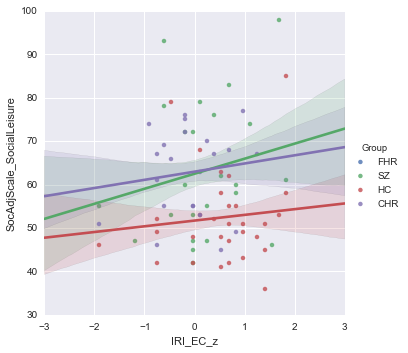

In [23]:
%Rpush raw

%R iri_ec_sl <- aov(SocAdjScale_SocialLeisure ~ as.factor(IRI_EC_z)*as.factor(Group),data=raw)
%R print (summary(iri_ec_sl))

sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_EC_z',hue='Group',
           units='ID',ci=68,data=raw)
sns.plt.ylim(30,100)

                                     Df Sum Sq Mean Sq F value Pr(>F)    
as.factor(Group)                      3  49779   16593 106.206 <2e-16 ***
as.factor(IRI_PD_z)                  30   3301     110   0.704  0.839    
as.factor(Group):as.factor(IRI_PD_z) 23   1813      79   0.505  0.958    
Residuals                            40   6249     156                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


(30, 100)

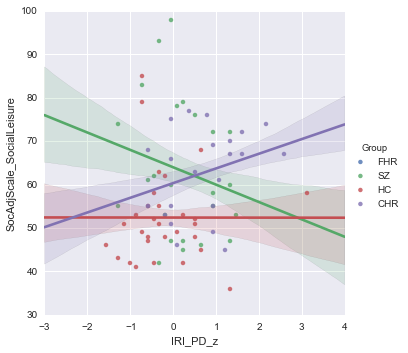

In [24]:
%R iri_pd_sl <- aov(SocAdjScale_SocialLeisure ~ as.factor(Group)*as.factor(IRI_PD_z),data=raw)
%R print (summary(iri_pd_sl))

sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_PD_z',hue='Group',
           units='ID',ci=68,data=raw)
sns.plt.ylim(30,100)

                                     Df Sum Sq Mean Sq F value Pr(>F)    
as.factor(Group)                      3  49779   16593 171.347 <2e-16 ***
as.factor(IRI_PT_z)                  25   4030     161   1.665 0.0721 .  
as.factor(Group):as.factor(IRI_PT_z) 27   3363     125   1.286 0.2289    
Residuals                            41   3970      97                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


(30, 100)

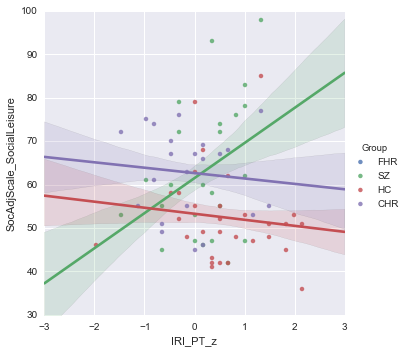

In [25]:
%R iri_pt_sl <- aov(SocAdjScale_SocialLeisure ~ as.factor(Group)*as.factor(IRI_PT_z),data=raw)
%R print (summary(iri_pt_sl))

sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_PT_z',hue='Group',
           units='ID',ci=68,data=raw)
sns.plt.ylim(30,100)

                                     Df Sum Sq Mean Sq F value Pr(>F)    
as.factor(Group)                      3  49779   16593 181.891 <2e-16 ***
as.factor(IRI_FS_z)                  32   4460     139   1.528  0.109    
as.factor(Group):as.factor(IRI_FS_z) 25   3620     145   1.587  0.100    
Residuals                            36   3284      91                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


(30, 100)

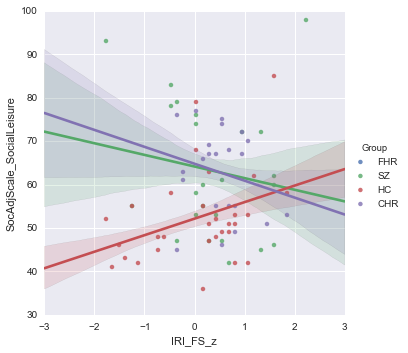

In [26]:
%R iri_fs_sl <- aov(SocAdjScale_SocialLeisure ~ as.factor(Group)*as.factor(IRI_FS_z),data=raw)
%R print (summary(iri_fs_sl))

sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_FS_z',hue='Group',
           units='ID',ci=68,data=raw)
sns.plt.ylim(30,100)

                                     Df Sum Sq Mean Sq F value   Pr(>F)    
as.factor(Group)                      3  53040   17680  48.348 4.78e-13 ***
as.factor(IRI_EC_z)                  28   7108     254   0.694    0.841    
as.factor(Group):as.factor(IRI_EC_z) 27  12265     454   1.242    0.265    
Residuals                            38  13896     366                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


(-10, 120)

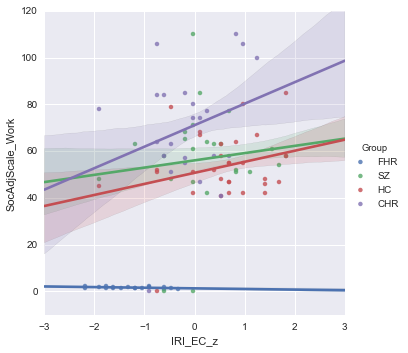

In [27]:
%R iri_ec_w <- aov(SocAdjScale_Work ~ as.factor(Group)*as.factor(IRI_EC_z),data=raw)
%R print (summary(iri_ec_w))

sns.lmplot(y='SocAdjScale_Work',x='IRI_EC_z',hue='Group',units='ID',
           ci=68,data=raw)
sns.plt.ylim(-10,120)

                                     Df Sum Sq Mean Sq F value  Pr(>F)    
as.factor(Group)                      3  53040   17680  86.556 < 2e-16 ***
as.factor(IRI_PD_z)                  30  16928     564   2.763 0.00145 ** 
as.factor(Group):as.factor(IRI_PD_z) 23   8170     355   1.739 0.06120 .  
Residuals                            40   8170     204                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


(-10, 120)

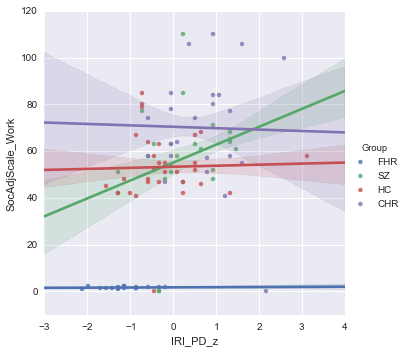

In [28]:
%R iri_pd_w <- aov(SocAdjScale_Work ~ as.factor(Group)*as.factor(IRI_PD_z),data=raw)
%R print (summary(iri_pd_w))


sns.lmplot(y='SocAdjScale_Work',x='IRI_PD_z',hue='Group',units='ID',
           ci=68,data=raw)
sns.plt.ylim(-10,120)

                                     Df Sum Sq Mean Sq F value   Pr(>F)    
as.factor(Group)                      3  53040   17680  51.512 5.75e-14 ***
as.factor(IRI_PT_z)                  25  12666     507   1.476    0.131    
as.factor(Group):as.factor(IRI_PT_z) 27   6532     242   0.705    0.830    
Residuals                            41  14072     343                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


(-10, 120)

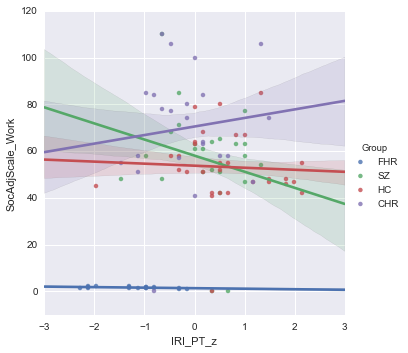

In [29]:
%R iri_pt_w <- aov(SocAdjScale_Work ~ as.factor(Group)*as.factor(IRI_PT_z),data=raw)
%R print (summary(iri_pt_w))

sns.lmplot(y='SocAdjScale_Work',x='IRI_PT_z',hue='Group',units='ID',
           ci=68,data=raw)
sns.plt.ylim(-10,120)

                                     Df Sum Sq Mean Sq F value   Pr(>F)    
as.factor(Group)                      3  53040   17680  53.424 3.78e-13 ***
as.factor(IRI_FS_z)                  32   9064     283   0.856    0.670    
as.factor(Group):as.factor(IRI_FS_z) 26  12622     485   1.467    0.144    
Residuals                            35  11583     331                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
13 observations deleted due to missingness


(-10, 120)

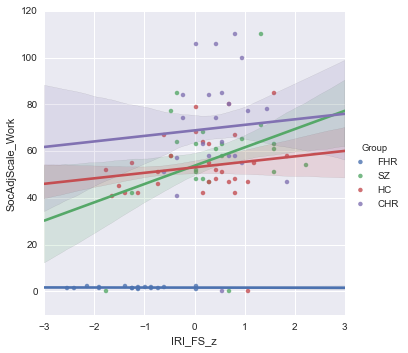

In [30]:
%R iri_fs_w <- aov(SocAdjScale_Work ~ as.factor(Group)*as.factor(IRI_FS_z),data=raw)
%R print (summary(iri_fs_w))

sns.lmplot(y='SocAdjScale_Work',x='IRI_FS_z',hue='Group',units='ID',
           ci=68,data=raw)
sns.plt.ylim(-10,120)